Brain Tumor Classification (CNN) - Cordelia, Al, Spencer, Rahil

In [2]:
import os
import zipfile
import shutil
from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

# Model traning, image processing
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
# Extracting images from the zip file

def extract_and_split(zip_path, output_dir, split_ratio=0.8):
    """
    Extracts a zip file, merges class folders from training and testing, and performs a stratified train-test split.

    Parameters:
        zip_path (str): Path to the archive.zip file.
        output_dir (str): Path to the output directory where the train-test split will be stored.
        split_ratio (float): Proportion of data to use for training (default is 0.8).
    """
    # Temporary extraction path
    temp_dir = os.path.join(output_dir, "temp")

    # Ensure output and temp directories exist
    os.makedirs(temp_dir, exist_ok=True)
    os.makedirs(output_dir, exist_ok=True)

    # Extract zip file
    print("Extracting zip file...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)

    # Paths to class folders inside the training and testing directories
    class_folders = ['glioma', 'meningioma', 'notumor', 'pituitary']
    dataset_folder = os.path.join(output_dir, "dataset")
    os.makedirs(dataset_folder, exist_ok=True)

    # Merge all class folders from training and testing
    print("Merging training and testing folders...")
    for class_name in class_folders:
        class_dir = os.path.join(dataset_folder, class_name)
        os.makedirs(class_dir, exist_ok=True)
        for base_folder in ['Training', 'Testing']:
            base_path = os.path.join(temp_dir, base_folder, class_name)
            if os.path.exists(base_path):
                for file_name in os.listdir(base_path):
                    src_file = os.path.join(base_path, file_name)
                    dest_file = os.path.join(class_dir, file_name)
                    if os.path.isfile(src_file):
                        shutil.copy(src_file, dest_file)

    # Create train-test split directories
    train_folder = os.path.join(output_dir, "train")
    test_folder = os.path.join(output_dir, "test")
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Perform stratified splitting for each class
    print("Performing stratified train-test split...")
    for class_name in class_folders:
        class_dir = os.path.join(dataset_folder, class_name)
        all_files = os.listdir(class_dir)

        # Stratified train-test split
        train_files, test_files = train_test_split(
            all_files, train_size=split_ratio, random_state=42
        )

        # Copy files to train/test directories for the respective class
        class_train_dir = os.path.join(train_folder, class_name)
        class_test_dir = os.path.join(test_folder, class_name)
        os.makedirs(class_train_dir, exist_ok=True)
        os.makedirs(class_test_dir, exist_ok=True)

        for file_name in train_files:
            shutil.copy(os.path.join(class_dir, file_name), class_train_dir)
        for file_name in test_files:
            shutil.copy(os.path.join(class_dir, file_name), class_test_dir)

    # Clean up temporary files
    print("Cleaning up temporary files...")
    shutil.rmtree(temp_dir)

    print("Train-test split completed.")

In [4]:
# Example usage
zip_path = "archive.zip"  # Path to your zip file
output_dir = "data"    # Path to the output directory

extract_and_split(zip_path, output_dir)
# if you get a zip file error, it hasn't finished uploading. Wait a few minutes

Extracting zip file...
Merging training and testing folders...
Performing stratified train-test split...
Cleaning up temporary files...
Train-test split completed.


In [8]:
data_dir = "./data/train"
batch_size = 32
img_size = (120, 120)

In [10]:
#load dataset
train_ds, val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="both",
    seed=2045,
    image_size=img_size,
    batch_size=batch_size
)

Found 5617 files belonging to 4 classes.
Using 4494 files for training.
Using 1123 files for validation.


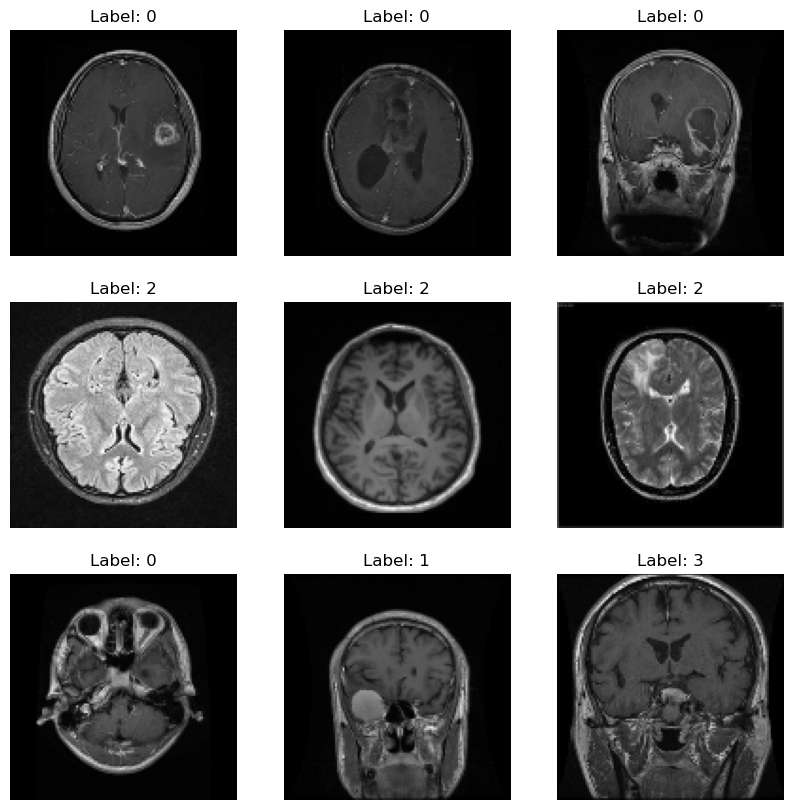

In [12]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Show the first 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()
    break

In [14]:
# Optional: Cache datasets for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
# Normalize images (scale pixel values to [0,1])
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [18]:
# Creating one hot incoding for the labels
def preprocess_to_one_hot(features, labels):
    # One-hot encode the labels
    labels = tf.one_hot(tf.cast(labels, tf.int32), depth=4)  # 4 = num_classes
    return features, labels

# Apply preprocessing to the train and validation datasets
train_ds = train_ds.map(preprocess_to_one_hot)
val_ds = val_ds.map(preprocess_to_one_hot)

In [20]:
train_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [22]:
#Creating the model architecture
num_classes = 4
img_rows, img_cols = img_size


model = Sequential([
    Input(shape=(img_rows, img_cols, 3)),  # Input for color images
    # Convolutional Layer 1
    Conv2D(4, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Convolutional Layer 2
    Conv2D(8, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Convolutional Layer 3
    Conv2D(16, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Global Average Pooling (replaces Flatten)
    GlobalAveragePooling2D(),

    # Fully Connected Layers
    Dense(32, activation='relu'),  # Reduce units to manage parameters
    Dropout(0.4),
    Dense(num_classes, activation='softmax')  # Output layer
])

In [24]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 118, 118, 4)    │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 118, 118, 4)    │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 59, 59, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 57, 57, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 26, 26, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,364 (9.23 KB)

 Trainable params: 2,308 (9.02 KB)

 Non-trainable params: 56 (224.00 B)

In [26]:
sub_train = train_ds.take(500)
sub_val = val_ds.take(100)

In [28]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    verbose=1
)

Epoch 1/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.4493 - loss: 1.2268 - val_accuracy: 0.2823 - val_loss: 1.3933
Epoch 2/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6071 - loss: 0.9600 - val_accuracy: 0.2627 - val_loss: 1.5150
Epoch 3/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6639 - loss: 0.8397 - val_accuracy: 0.2689 - val_loss: 1.5702
Epoch 4/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6865 - loss: 0.7970 - val_accuracy: 0.3998 - val_loss: 1.4165
Epoch 5/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7170 - loss: 0.7358 - val_accuracy: 0.5022 - val_loss: 1.2240
Epoch 6/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7103 - loss: 0.7222 - val_accuracy: 0.5423 - val_loss: 1.1170
Epoch 7/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7324 - loss: 0.6830 - val_accuracy: 0.6073 - val_loss: 1.0518
Epoch 8/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7309 - loss: 0.6697 - val_accu

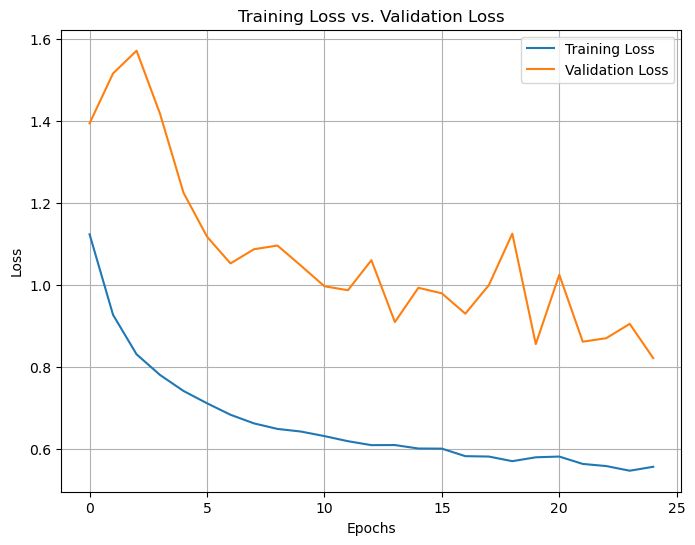

In [32]:
# Extract loss values from history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the losses
plt.figure(figsize=(8, 6))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
test_ds = image_dataset_from_directory(
    "data/test",               # Path to the test directory
    image_size=img_size,       # Target size for resizing images (e.g., (192, 192))
    batch_size=batch_size,     # Batch size
    shuffle=False              # Do not shuffle for consistent predictions
)
not_normalized_test_ds = test_ds

Found 1406 files belonging to 4 classes.


In [36]:
test_ds.class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

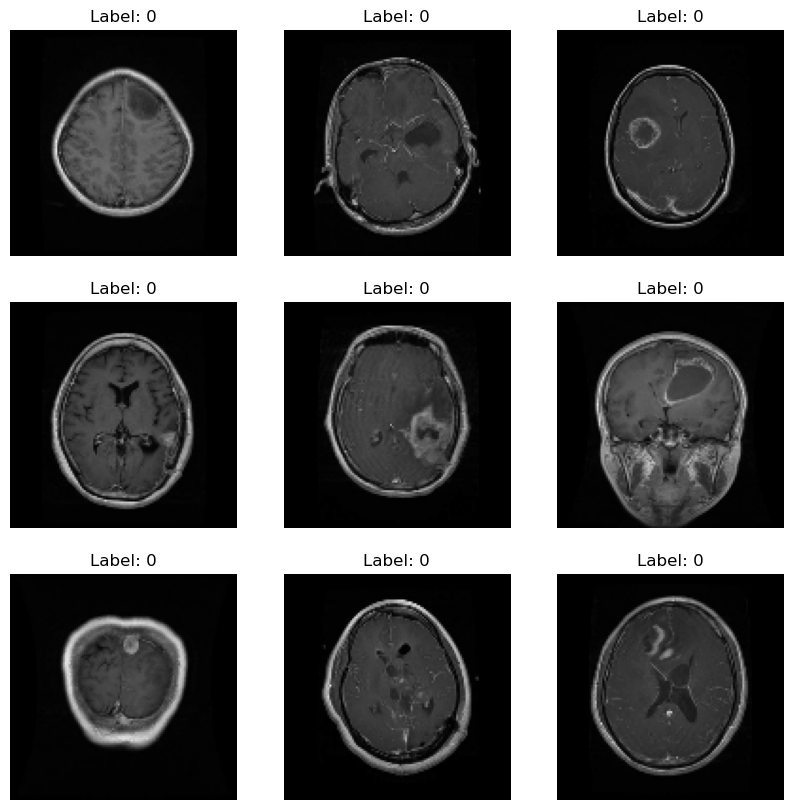

In [38]:
for images, labels in not_normalized_test_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Show the first 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()
    break

In [40]:
#Normalizing the images in test dataset
normalization_layer = tf.keras.layers.Rescaling(1./255)

test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [42]:
#Creating one hot incoding for the labels
test_ds = test_ds.map(preprocess_to_one_hot)

In [44]:
#Checking the shape of the test_ds
for images, labels in test_ds.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    print(f"Class labels: {labels.numpy()}")

Image batch shape: (32, 120, 120, 3)
Label batch shape: (32, 4)
Class labels: [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


2024-12-09 15:36:19.204068: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [46]:
results = model.evaluate(test_ds)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6946 - loss: 0.7510
Test Loss: 0.7488182187080383
Test Accuracy: 0.6927453875541687


In [48]:
predictions = model.predict(test_ds)

# Display predictions for the first batch
for i, pred in enumerate(predictions[:5]):
    print(f"Image {i}: Predicted class = {tf.argmax(pred).numpy()}, Probabilities = {pred}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Image 0: Predicted class = 0, Probabilities = [8.97495031e-01 1.01216204e-01 1.93977721e-05 1.26941386e-03]
Image 1: Predicted class = 0, Probabilities = [0.94274884 0.02040697 0.00144311 0.03540114]
Image 2: Predicted class = 0, Probabilities = [9.9767697e-01 1.3902554e-03 6.3261657e-04 3.0013529e-04]
Image 3: Predicted class = 0, Probabilities = [7.8449279e-01 6.3341364e-02 1.3020409e-04 1.5203565e-01]
Image 4: Predicted class = 0, Probabilities = [0.85319424 0.04691301 0.00172434 0.09816837]


22/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

2024-12-09 15:36:26.241988: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


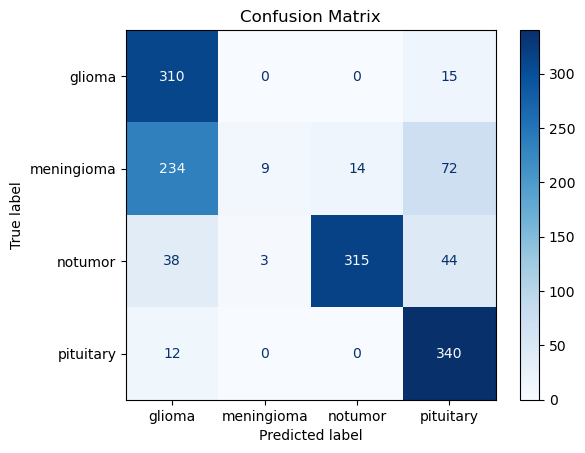

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Get ground truth labels
true_labels = []
for _, labels in test_ds:
    true_labels.extend(labels.numpy())

# Convert true_labels from one-hot encoding to class indices if necessary
true_labels = np.argmax(true_labels, axis=1) if len(np.array(true_labels).shape) > 1 else np.array(true_labels)

# Step 2: Get predicted labels
predictions = model.predict(test_ds)  # Get all predictions at once
predicted_labels = np.argmax(predictions, axis=1)

# Step 3: Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Step 4: Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['glioma', 'meningioma', 'notumor', 'pituitary'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [52]:
# Step 1: Make predictions on the test dataset
true_labels = []
images = []
for img_batch, label_batch in not_normalized_test_ds:
    true_labels.extend(label_batch.numpy())
    images.extend(img_batch.numpy())

In [54]:
#predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

# Step 2: Identify misclassified images
true_labels = np.array(true_labels)
meningioma_misclassified_glioma_indices = np.where((true_labels == 1) & (predicted_labels == 0))[0]  # True: meningioma (1), Predicted: glioma (0)
meningioma_correct_indices = np.where((true_labels == 1) & (predicted_labels == 1))[0]   # True: meningioma (1), Predicted: meningioma (1)
glioma_correct_indices = np.where((true_labels == 0) & (predicted_labels == 0))[0]  # True: glioma (0), Predicted: glioma (0)
pituitary_correct_indices = np.where((true_labels == 3) & (predicted_labels == 3))[0]  # True: pituitary (3), Predicted: pituitary (3)
notumor_correct_indices = np.where((true_labels == 2) & (predicted_labels == 2))[0]  # True: nontumor (2), Predicted: nontumor (2)
meningioma_misclassified_pituitary_indices = np.where((true_labels == 1) & (predicted_labels == 3))[0]  # True: meningioma (1), Predicted: pituitary (3)

In [56]:
print("incorrect: \n", meningioma_misclassified_glioma_indices, "\n Correct: \n", meningioma_correct_indices)

incorrect: 
 [333 343 346 349 350 351 352 353 355 357 358 360 362 363 364 365 366 367
 368 369 370 371 373 374 375 376 377 379 380 381 382 383 384 385 386 388
 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406
 407 410 411 412 413 414 415 416 417 418 419 420 429 435 437 438 439 442
 443 444 445 446 447 448 452 453 454 455 457 458 459 460 461 462 463 464
 465 467 468 469 471 472 474 476 477 478 479 480 481 482 483 484 485 487
 488 489 490 491 492 493 501 502 505 506 508 509 510 513 514 515 520 521
 522 524 526 527 528 529 530 531 532 533 536 537 538 539 541 544 545 546
 547 548 549 550 551 552 553 554 555 556 558 559 560 561 562 563 566 567
 568 569 570 571 573 574 575 577 578 579 580 581 582 583 584 585 587 588
 589 590 591 592 594 595 596 597 598 599 601 602 604 605 606 607 608 609
 610 611 612 613 614 616 617 619 621 623 624 625 626 627 628 629 630 631
 632 633 634 635 636 638 639 640 641 644 645 646 647 649 650 651 652 653] 
 Correct: 
 [329 431 450 517 518 525

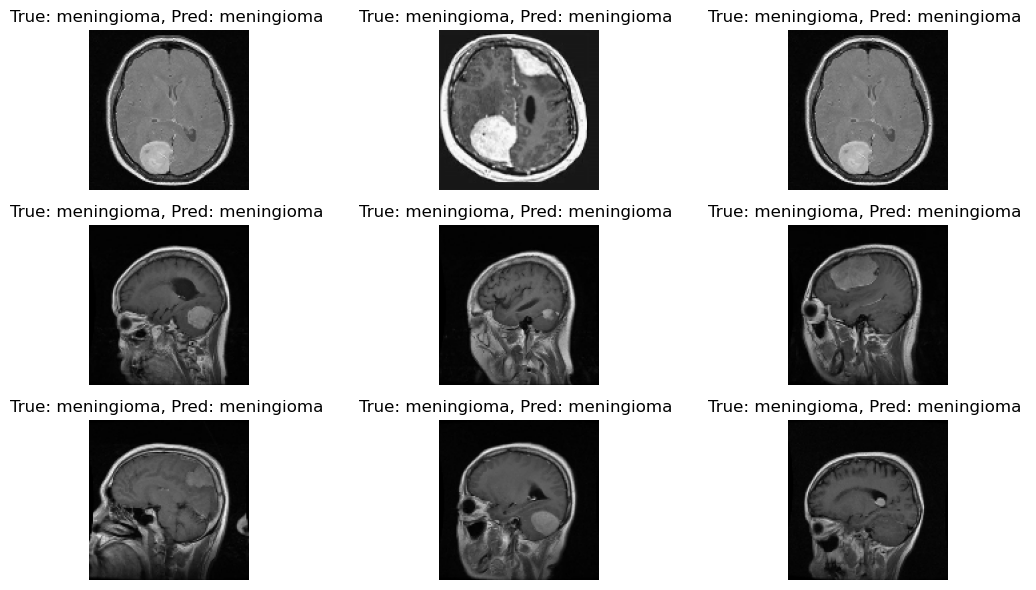

In [58]:
# Step 3: Visualize the misclassified images
plt.figure(figsize=(12, 6))
for i, idx in enumerate(meningioma_correct_indices[:9]):  # Show up to 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[idx].astype("uint8"))
    plt.title(f"True: meningioma, Pred: meningioma ")
    plt.axis("off")

plt.tight_layout()
plt.show()

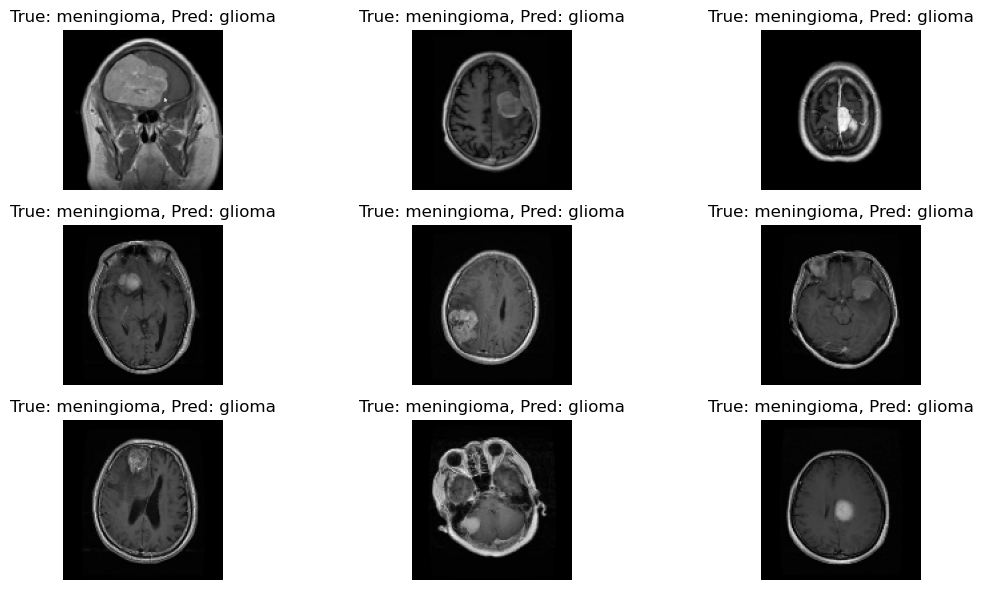

In [60]:
# Step 3: Visualize the misclassified images
plt.figure(figsize=(12, 6))
for i, idx in enumerate(meningioma_misclassified_glioma_indices[:9]):  # Show up to 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[idx].astype("uint8"))
    plt.title(f"True: meningioma, Pred: glioma")
    plt.axis("off")

plt.tight_layout()
plt.show()

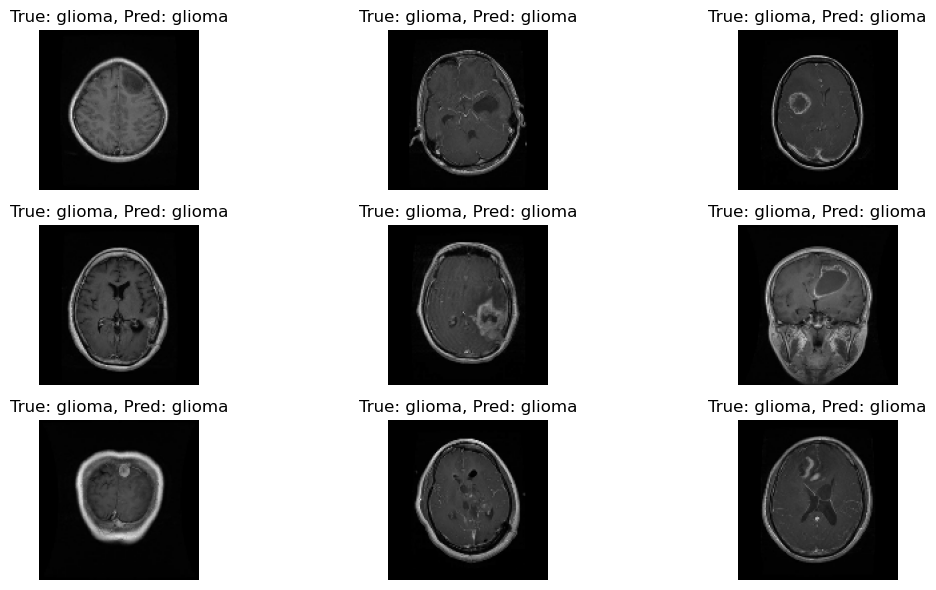

In [62]:
# Step 3: Visualize the misclassified images
plt.figure(figsize=(12, 6))
for i, idx in enumerate(glioma_correct_indices[:9]):  # Show up to 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[idx].astype("uint8"))
    plt.title(f"True: glioma, Pred: glioma")
    plt.axis("off")

plt.tight_layout()
plt.show()

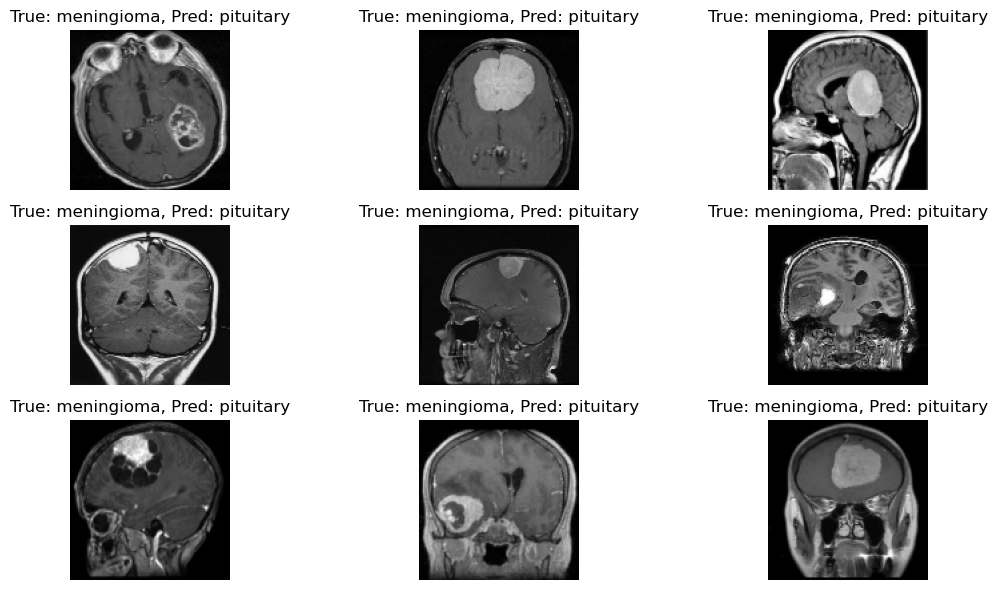

In [64]:
# Step 3: Visualize the misclassified images
plt.figure(figsize=(12, 6))
for i, idx in enumerate(meningioma_misclassified_pituitary_indices[:9]):  # Show up to 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[idx].astype("uint8"))
    plt.title(f"True: meningioma, Pred: pituitary")
    plt.axis("off")

plt.tight_layout()
plt.show()

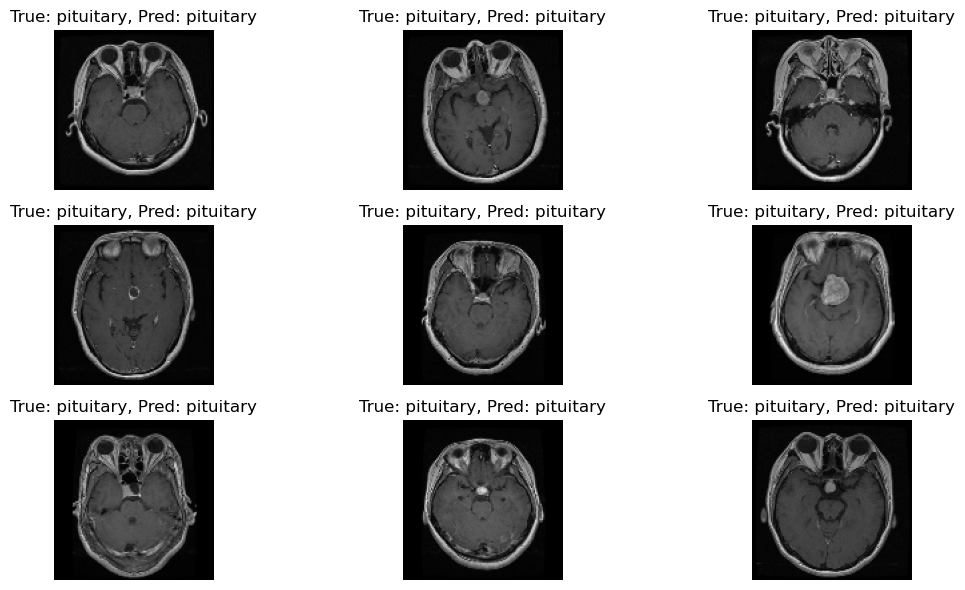

In [66]:

plt.figure(figsize=(12, 6))
for i, idx in enumerate(pituitary_correct_indices[:9]):  # Show up to 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[idx].astype("uint8"))
    plt.title(f"True: pituitary, Pred: pituitary")
    plt.axis("off")

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━

2024-12-09 15:38:11.839839: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


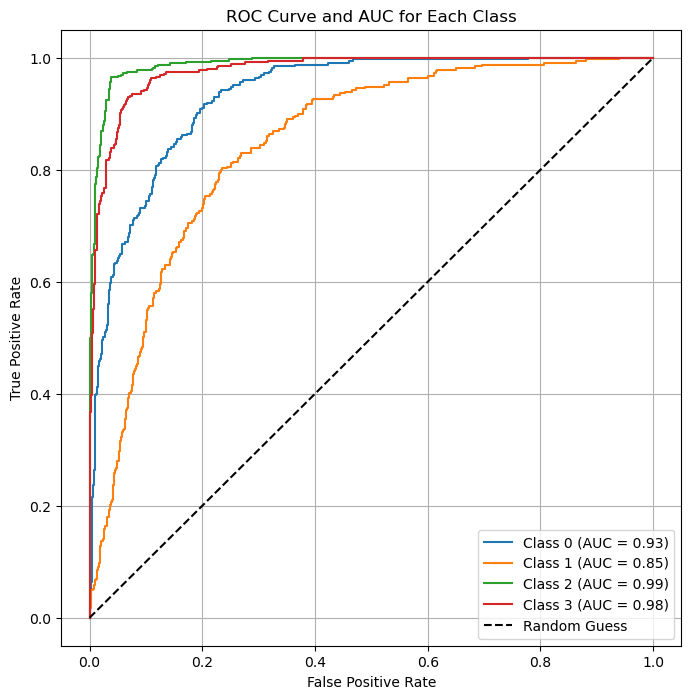

In [68]:
from sklearn.metrics import roc_curve, auc

# Step 1: Get true labels and predicted probabilities
true_labels = []
predicted_probs = []

for img_batch, label_batch in test_ds:
    true_labels.extend(label_batch.numpy())
    predicted_probs.extend(model.predict(img_batch))

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)

# Step 2: Compute ROC and AUC for each class
n_classes = true_labels.shape[1]  # Number of classes
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 3: Plot the ROC curves for each class
plt.figure(figsize=(8, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Add diagonal line
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

# Plot settings
plt.title("ROC Curve and AUC for Each Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()